The purpose of this notebook is to show how to **read and process** some research data using xarray library.

See xarray documentation here: (https://docs.xarray.dev/en/stable/index.html)


# general imports

In [3]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy

import numpy as np
import xarray as xr

import PIL # python image library for reading tiff files

In [4]:
# It would be good to have interactive plots if ipympl is installed.
# See: https://matplotlib.org/ipympl/

try:
    %matplotlib inline
except:
    %matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# setting up the example data path

In [6]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
except:
    pass

In [10]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/tutorial/file_types/image/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['NIST-LaB6.tiff', 'NIST-LaB6.png', 'flower.jpg']

# reading a tiff image file as a numpy array and plotting without using xarray
(This is an inefficient way and you will see why later)

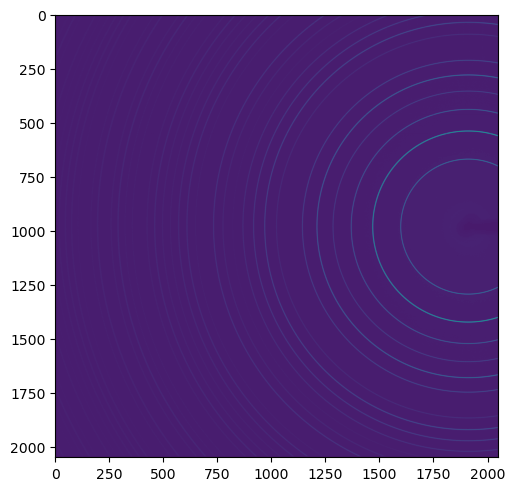

In [13]:
# first we need to read image as numpy array
img = np.array(PIL.Image.open('NIST-LaB6.tiff'))

# then plot using imshow
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
ax.set_aspect('equal')

# reading a tiff image file as xarray dataarray and plotting with xarray.

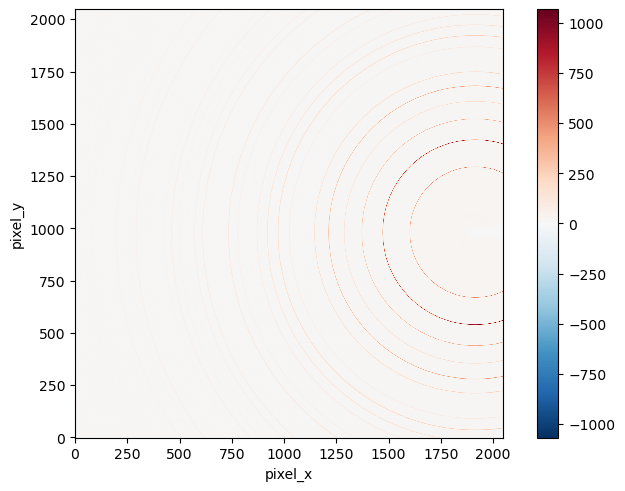

In [16]:
# first we need to read image as numpy array
img = np.array(PIL.Image.open('NIST-LaB6.tiff'))


# then we create an xarray DataArray object
da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax) # this line does the plotting for us and adds colorbar and figure axis labels.
ax.set_aspect('equal')

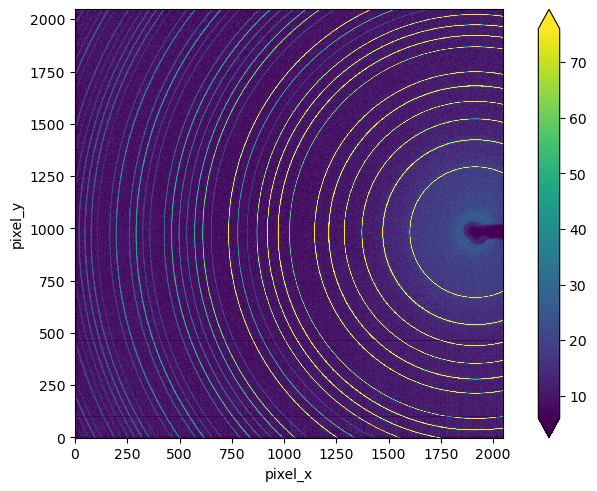

In [18]:
# one of the most useful plotting keywords of xarray is "robust".
# By setting robust=True, we can see the image in a better coloring scale
# without any additional user input.

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax,robust=True)
ax.set_aspect('equal')

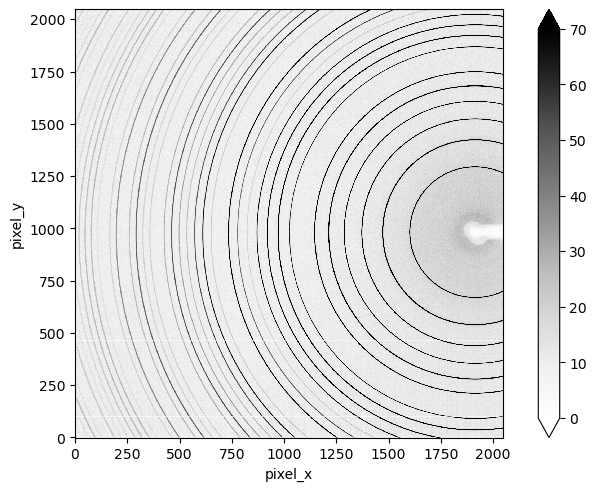

In [20]:
# We can easily change the color map and set the vmin value to 0

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')

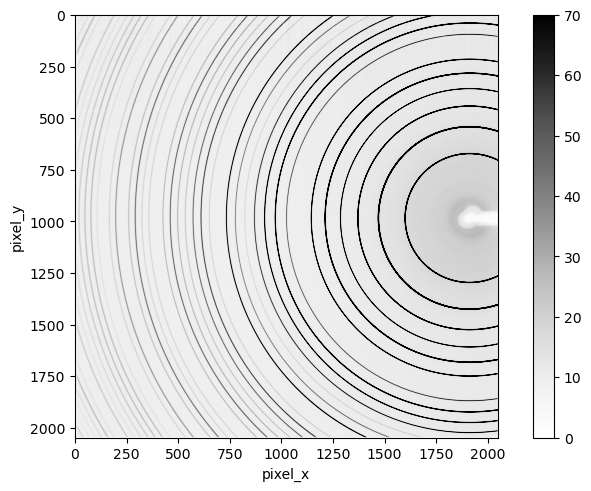

In [22]:
# in order to get above plot, we need to add some manual stuff

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(img,vmin=0,vmax=70,cmap='Greys') # we learned 70 here from xarray plot

# --- xarray plotting does these for us automatically 
cb = fig.colorbar(im) 
ax.set_xlabel('pixel_x')
ax.set_ylabel('pixel_y')
# ---------------------------------------------------

ax.set_aspect('equal')

# NOTE: There are some detector defects on the image. 
# See horizontal lines on pixel_x = 102 & pixel_y = 465 in xarray plot above.
# But those lines are not seen on this plot.

Adding x,y labels or colorbar is not only advantage of xarray. There are plenty of more\
functionality that are not easy with using standard numpy and matplotlib functions.\
Examples below show some of those functionalities.

# more examples with xarray

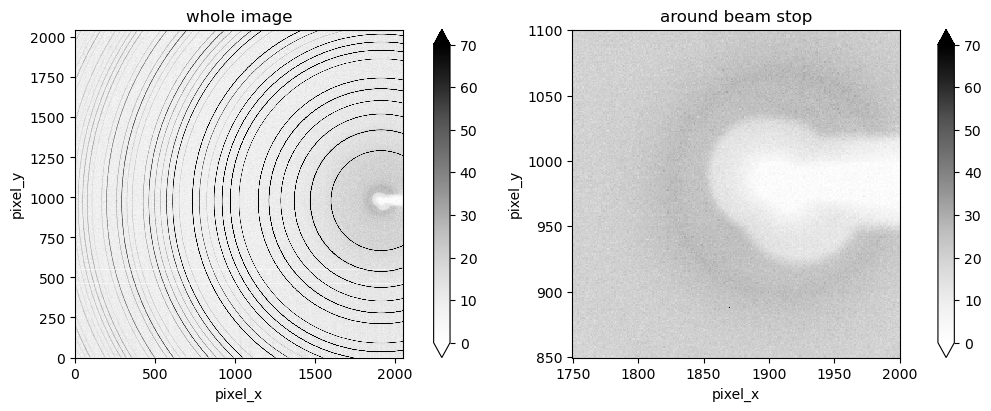

In [24]:
# The features around pixel_x=1910, pixel_y=980 are coming from beam stop.
# We can easily zoom in those areas in a second plot

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')
ax.set_title('whole image')


ax = fig.add_subplot(1,2,2)
da_sel = da.sel(pixel_x=slice(1750,2000)).sel(pixel_y=slice(850,1100))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')
ax.set_title('around beam stop');

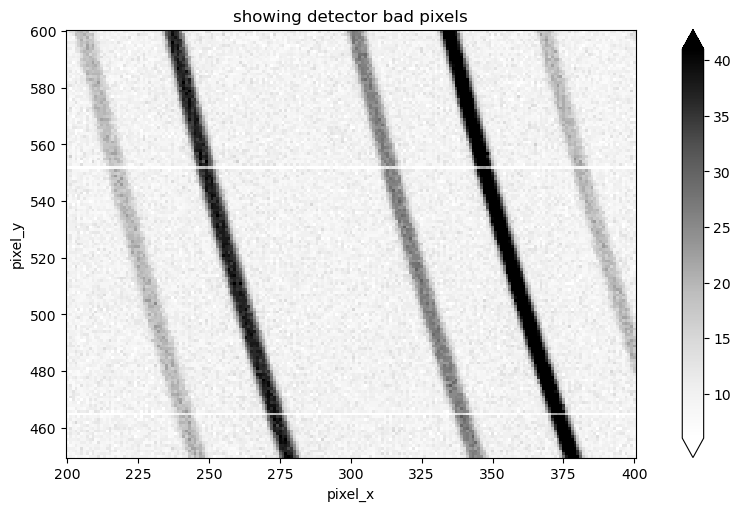

In [26]:
# Same as above for detector artefacts

fig = plt.figure(figsize=(8,5))


ax = fig.add_subplot(1,1,1)
da_sel = da.sel(pixel_x=slice(200,400)).sel(pixel_y=slice(450,600))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys')
ax.set_aspect('equal')
ax.set_title('showing detector bad pixels');

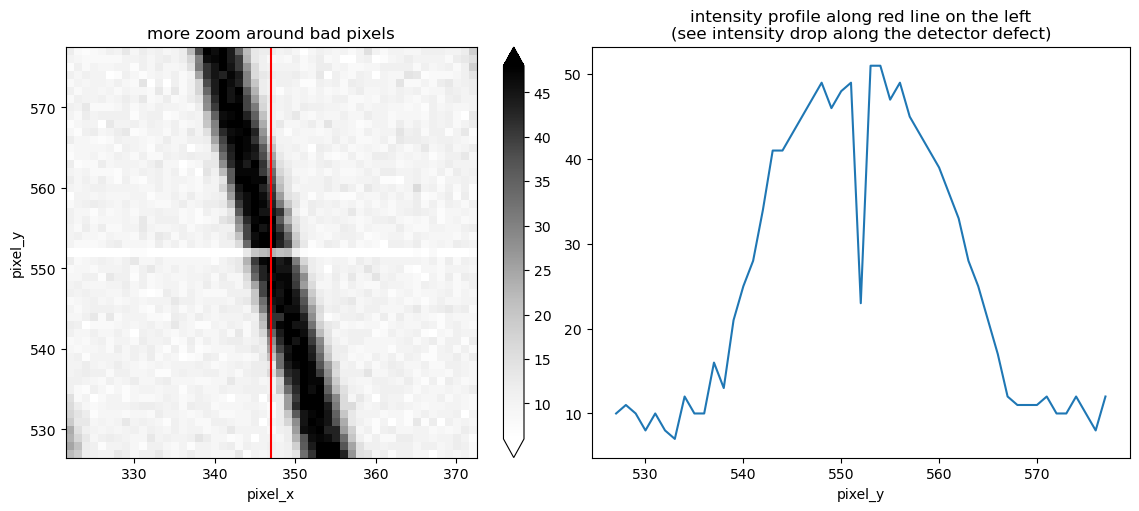

In [28]:
# here we further zoom into defects and get line profile

fig = plt.figure(figsize=(12,5))


ax = fig.add_subplot(1,2,1)
da_sel = da.sel(pixel_x=slice(347-25,347+25)).sel(pixel_y=slice(552-25,552+25))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys')
ax.axvline(x=347,color='r')
ax.set_aspect('equal')
ax.set_title('more zoom around bad pixels')

ax = fig.add_subplot(1,2,2)
da_sel.sel(pixel_x=347,method='nearest').plot()
ax.set_title('intensity profile along red line on the left\n(see intensity drop along the detector defect)');


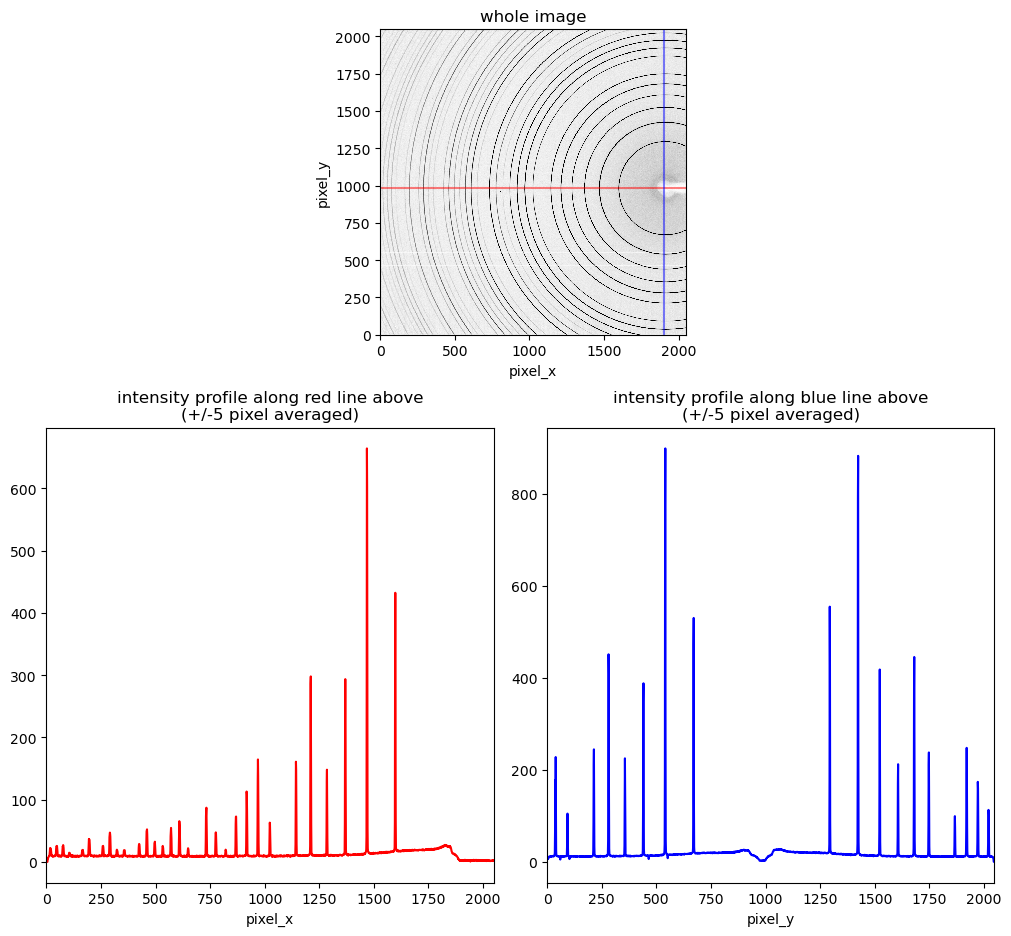

In [30]:
# This is similar way of selecting and averaging profile

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,3,2)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)
ax.axhline(y=983,color='r',alpha=0.5)
ax.axvline(x=1900,color='b',alpha=0.5)
ax.set_aspect('equal')
ax.set_title('whole image')


ax = fig.add_subplot(2,2,3)
da_sel = da.sel(pixel_y=slice(983-5,983+5)).mean(dim='pixel_y') # here we first select and then average
da_sel.plot(ax=ax,color='r')
ax.set_title('intensity profile along red line above\n(+/-5 pixel averaged)')
ax.set_xlim([0,2048])

ax = fig.add_subplot(2,2,4)
da_sel = da.sel(pixel_x=slice(1900-5,1900+5)).mean(dim='pixel_x') # here we first select and then average
da_sel.plot(ax=ax,color='b')
ax.set_title('intensity profile along blue line above\n(+/-5 pixel averaged)')
ax.set_xlim([0,2048]);

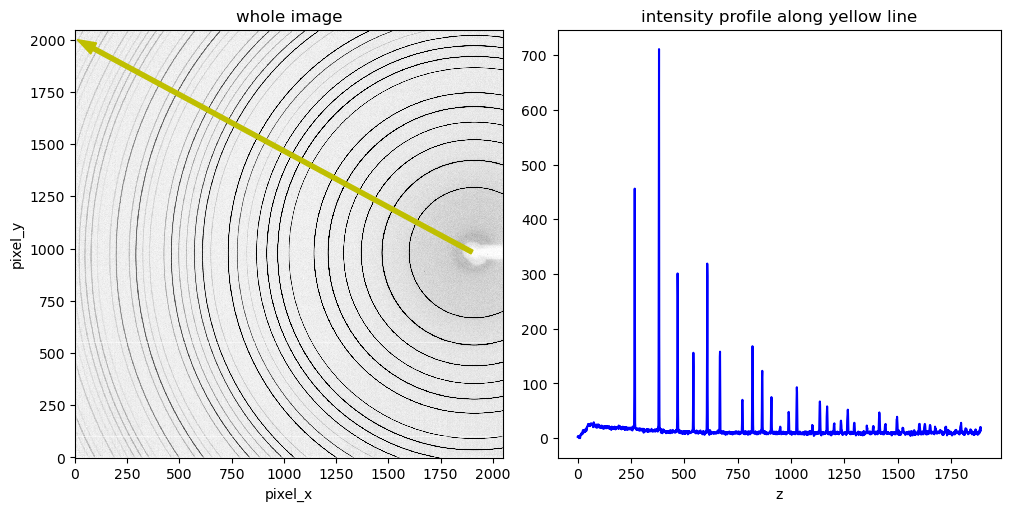

In [32]:
# this is more advanced way of getting line profile along yellow line below

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)

# poi
p1 = (1900,983) # the center of the pattern
p2 = (10,2000)
# arrow
ax.arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],width=20,color="y",length_includes_head=True)

ax.set_aspect('equal')
ax.set_title('whole image')



ax = fig.add_subplot(1,2,2)

from skimage.draw import line
# tuple storing x and y arrays representing corresponding x and y coordinates of our line
pline = line(p1[0],p1[1],p2[0],p2[1])
# creation of x_array from x coords of our line tuple
x = xr.DataArray(pline[0], dims="z")
# creation of x_array from y coords of our line tuple
y = xr.DataArray(pline[1], dims="z")
da_sel = da.interp(pixel_x=x,pixel_y=y)
da_sel.plot(ax=ax, color='b')

ax.set_title('intensity profile along yellow line');

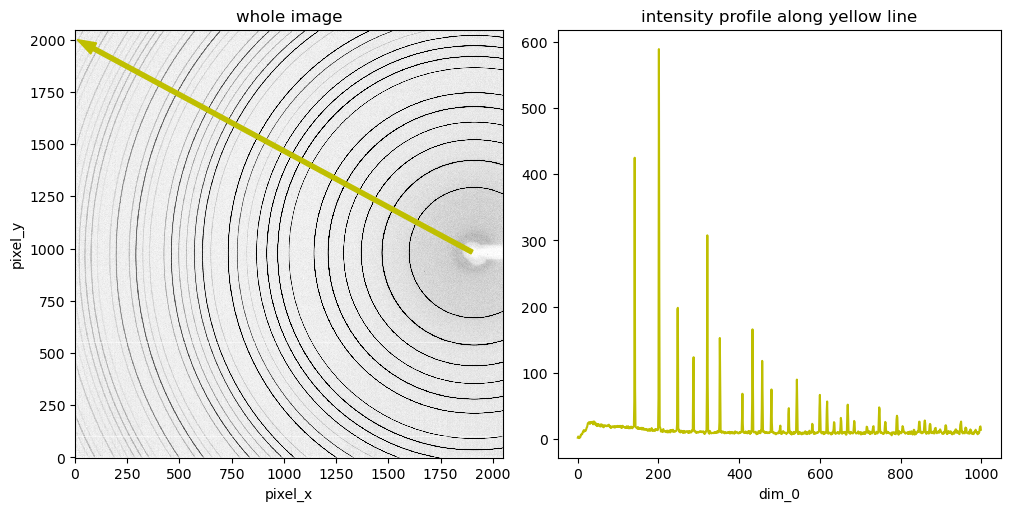

In [34]:
# It seems that we can further simplify this without using "from skimage.draw import line"
# this method also enables us to set number of points along the line (100 below)


fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)

# poi
p1 = (1900,983) # the center of the pattern
p2 = (10,2000)
# arrow
ax.arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],width=20,color="y",length_includes_head=True)
ax.set_aspect('equal')
ax.set_title('whole image')




ax = fig.add_subplot(1,2,2)
da_int = da.interp(pixel_x=xr.DataArray(np.linspace(p1[0],p2[0],1000)),
                   pixel_y=xr.DataArray(np.linspace(p1[1],p2[1],1000)))
da_int.plot(ax=ax, color='y')

ax.set_title('intensity profile along yellow line');

In [38]:
# here is a much more advanced work done by 
# https://github.com/pmeshkov & https://github.com/KMorell
# adjustment of previously used center to get real center
# as well as fixed radii for blue rings
actual_center = np.add(p1,(17,-3))
radius = 315
tolerance = 10
radius1 = 200#radius-tolerance
radius2 = 1800#radius+tolerance


from skimage.draw import circle_perimeter

# finding every point in the sliver of the circle

circle = 0
data_values = da.values
sum_list = []
average_intensity = []

for i in np.arange(radius1, radius2):
    circle = circle_perimeter(actual_center[0],actual_center[1],i)
    for j in np.arange(0,len(circle[0])):
        try:
            sum_list = np.append(sum_list,data_values[circle[1][j]][circle[0][j]])
        except:
            continue
    average_intensity = np.append(average_intensity,np.average(sum_list))
    sum_list = []
print("complete")

complete


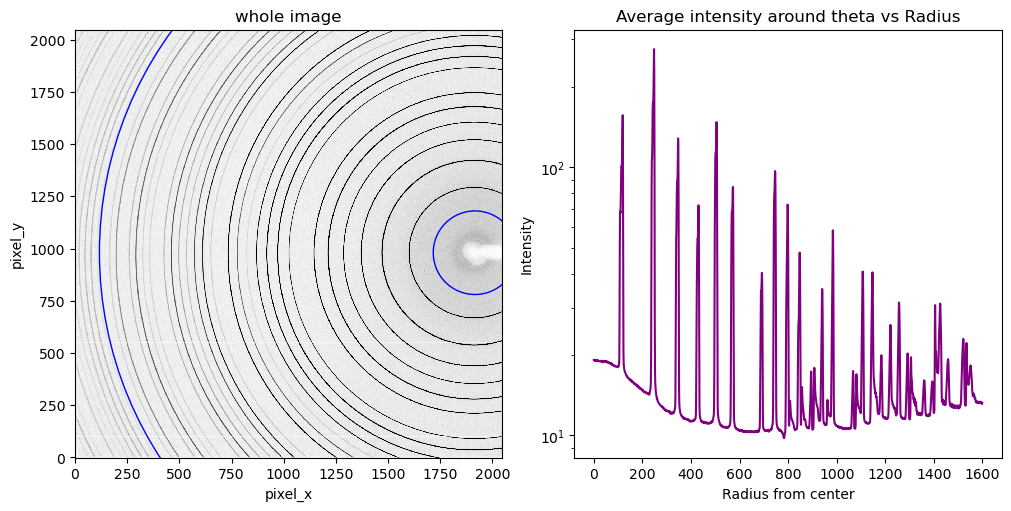

In [40]:
fig = plt.figure(figsize=(10,5))
# plot whole image
ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)
ax.set_title('whole image')

circle1 = plt.Circle(actual_center, radius1, color='b', fill=False)
circle2 = plt.Circle(actual_center, radius2, color='b', fill=False)
ax.add_patch(circle1)
ax.add_patch(circle2)

intensity_xarray = xr.DataArray(average_intensity)

ax = fig.add_subplot(1,2,2)
intensity_xarray.plot(color='purple')
ax.set_xlabel("Radius from center")
ax.set_ylabel("Intensity")
ax.set_yscale('log')

ax.set_title('Average intensity around theta vs Radius');